## Quantum Random Walk
This notebook simulates stocks with a random walk based on random numbers generated
by a quantum computer.

### Setup environment

In [112]:
# Imports
from datetime import datetime
import pandas as pd
import qiskit as qml
from qiskit.providers.ibmq import least_busy
import matplotlib.pyplot as plt

In [113]:
# Configuration
LOCAL_SIMULATION = False
SHOTS = 8000
OUTPUT_PATH = "../output/simulation_numbers.csv"

In [114]:
# Load IBMQ account
if not qml.IBMQ.active_account():
    qml.IBMQ.load_account()

In [115]:
# Get backend
provider = qml.IBMQ.get_provider(hub='ibm-q')

if LOCAL_SIMULATION:
    backend = qml.Aer.get_backend('aer_simulator')
else:
    backend = least_busy(provider.backends(simulator=False, operational=True))

print("Using Backend:", backend)

Using Backend: ibmq_armonk


### Generate random numbers

In [116]:
# Define circuit
circuit = qml.QuantumCircuit(1)
circuit.h(0)
circuit.measure_all()
compiled_circuit = qml.transpile(circuit, backend)

In [117]:
# Run circuit
print("Running circuit:", datetime.now())

result = backend.run(compiled_circuit, memory=True, shots=SHOTS).result()
random_numbers = result.get_memory()

print("Finished:", datetime.now())

Running circuit: 2021-11-22 22:08:29.935837
Finished: 2021-11-22 22:11:06.093108


In [118]:
# Print numbers
bernoulli_frame = pd.DataFrame({"x": random_numbers})
bernoulli_frame["x"] = bernoulli_frame["x"].astype("int")
print(bernoulli_frame.head())

   x
0  1
1  1
2  1
3  1
4  1


Positive: 3986
Negative: 4014


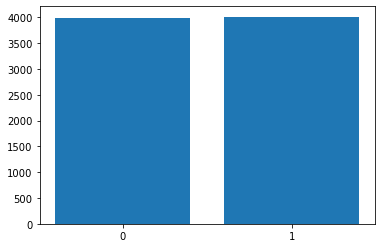

In [119]:
# Evaluate distribution
x = bernoulli_frame["x"]

positive = len(x[x == 1])
negative = len(x[x == 0])

print("Positive:", positive)
print("Negative:", negative)

plt.bar(["0", "1"], [positive, negative])
plt.show()

In [120]:
# Store random numbers
bernoulli_frame.to_csv(OUTPUT_PATH, index=False)

### Perform simulation

In [121]:
# Perform simulation
total_numbers = len(bernoulli_frame)
simulation_rounds = 200
simulation_runs = total_numbers // simulation_rounds
p = 0.01
q = -0.01
open_price = 100.0

simulation_frame = None

for i in range(simulation_runs):
    start_index = i * simulation_rounds
    end_index = start_index + simulation_rounds

    current_frame = pd.DataFrame({"x": bernoulli_frame["x"][start_index:end_index]})
    current_frame.loc[current_frame["x"] == 1, "x"] = 1 + p
    current_frame.loc[current_frame["x"] == 0, "x"] = 1 + q
    current_frame["x"] = current_frame.cumprod()
    current_frame["price"] = open_price * current_frame["x"]
    current_frame["stock"] = i
    current_frame["day"] = range(1, simulation_rounds + 1)

    if start_index == 0:
        simulation_frame = current_frame
    else:
        simulation_frame = simulation_frame.append(current_frame, ignore_index=True)

    simulation_frame.reset_index(drop=True)

### Analyse outcome

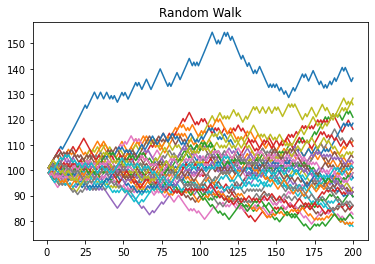

In [122]:
# Plot results
plt.figure()
plt.title("Random Walk")

for i in range(simulation_runs):
    stock_frame = simulation_frame[simulation_frame["stock"] == i]
    plt.plot(stock_frame["day"], stock_frame["price"], "-")

plt.show()

In [123]:
# Print some statistics
print("Runs:", simulation_runs)
print("Days per run:", simulation_rounds)
print("High price:", simulation_frame["price"].max())
print("Low price:", simulation_frame["price"].min())

Runs: 40
Days per run: 200
High price: 154.43674322227318
Low price: 76.4442019764744


In [124]:
# Store simulation results
simulation_frame.to_csv(OUTPUT_PATH, index=False)